## Loan defaulter prediction 
- This project explains 
  - Assumptions 
  - Approach  
  - Findings 
  - Analysis 
  - Feature generation
  - Model creation 
  
The task is to develop a model that can predict customer defaulting on loan. 

We will use two data sets `loan.csv`(customer performance on short-term loan product.) and `behaviour.csv` (customer usage of transactional finance platform, as well as mobile usage. Fields ending in `ym` like 6m represent an aggregation over the previous y months at that point in time)
Both datasets have unique identifier column 'consumer_id. 

Questions to answer about your approach 
1. How would you sample the data and why?
2. How would you gurantee the stability of this model(how would u avoid model bias)
3. Explain to consumers why they were declined credit. (what factors influence default)

**Approach to the problem**


- Merge the two datasets on customer_id 
- Perform statistical analysis
- Impute / drop the rows with missing values
- Run a random forest and choose the most relevant features 
- Perform exploratory data analysis 
- Build clusters to know which category of people easily default 
- Then build a prediction model to predict who will default
- Run ensemble learning using XGboost for maximum prediction accuracy 
- Run a GridsearchCV 
- Search for missing values and impute before running the neural net
- The AI approach will be to run a neural network to get the best accuracy 
- Run a GridsearchCV 
- Copy visualisations to Tableau and run the story. 



In [2]:
#conda install py-xgboost

In [3]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline 


from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [4]:
behaviour = pd.read_csv('/Users/mac/Downloads/Kola /behaviour.csv', sep =';')
loan = pd.read_csv('/Users/mac/Downloads/Kola /loan.csv', sep=';')


- First we are going to perform a brief analysis of the behaviour data 
- And next we are going to move to the loan data. 
- They will become 1 eventually but just not yet
### Behaviour data

In [5]:
print(behaviour.shape)
print(loan.shape)

(1297857, 131)
(51489, 5)


In [6]:
loan.sample(n=4)

,customer_id,date_lent,term_complete_yet,amount_due,amount_collected
37545,bafd075c4e83972831ed06f9b9766150,2027-01-05,1,15.47,15.47
6136,1ea666f5f3a974ec3e3c1a8c8512440a,2027-11-26,0,270.73,270.73
17837,591aed0cc06ce95af2dd3a42f0333096,2026-08-18,1,23.21,23.21
42361,d2e822d4369b061ecf8ff32ac835935e,2025-04-02,1,77.68,77.68


In [7]:
behaviour.isna().sum().sum()

3084123

In [8]:
#We have 131 columns in the behaviour dataset, I am interested in seeing all of them
pd.set_option('display.max_columns',999)

In [9]:
behaviour.sample(n=6)

,customer_id,row_creation_date,account_registration_date,money_in_freq_6m,money_in_freq_3m,money_in_freq_1m,money_in_value_6m,money_in_value_3m,money_in_value_1m,money_in_acceptors_freq_6m,money_in_acceptors_freq_3m,money_in_acceptors_freq_1m,money_in_max_value_6m,money_in_max_value_3m,money_in_max_value_1m,money_in_last_date,money_out_freq_6m,money_out_freq_3m,money_out_freq_1m,money_out_value_6m,money_out_value_3m,money_out_value_1m,money_out_acceptors_freq_6m,money_out_acceptors_freq_3m,money_out_acceptors_freq_1m,money_out_max_value_6m,money_out_max_value_3m,money_out_max_value_1m,money_out_last_date,bill_payment_freq_6m,bill_payment_freq_3m,bill_payment_freq_1m,bill_payment_value_6m,bill_payment_value_3m,bill_payment_value_1m,bill_payment_acceptors_freq_6m,bill_payment_acceptors_freq_3m,bill_payment_acceptors_freq_1m,bill_payment_max_value_6m,bill_payment_max_value_3m,bill_payment_max_value_1m,bill_payment_last_date,transfer_out_freq_6m,transfer_out_freq_3m,transfer_out_freq_1m,transfer_out_value_6m,transfer_out_value_3m,transfer_out_value_1m,transfer_out_acceptors_freq_6m,transfer_out_acceptors_freq_3m,transfer_out_acceptors_freq_1m,transfer_out_max_value_6m,transfer_out_max_value_3m,transfer_out_max_value_1m,transfer_out_last_date,transfer_in_freq_6m,transfer_in_freq_3m,transfer_in_freq_1m,transfer_in_value_6m,transfer_in_value_3m,transfer_in_value_1m,transfer_in_acceptors_freq_6m,transfer_in_acceptors_freq_3m,transfer_in_acceptors_freq_1m,transfer_in_max_value_6m,transfer_in_max_value_3m,transfer_in_max_value_1m,transfer_in_last_date,account_transfer_freq_6m,account_transfer_freq_3m,account_transfer_freq_1m,account_transfer_value_6m,account_transfer_value_3m,account_transfer_value_1m,account_transfer_accptrs_freq_6m,account_transfer_accptrs_freq_3m,account_transfer_accptrs_freq_1m,account_transfer_max_value_6m,account_transfer_max_value_3m,account_transfer_max_value_1m,account_transfer_last_date,phone_network_registration_date,airtime_used_value_6m,airtime_used_value_3m,airtime_used_value_1m,days_airtime_below_freq_6m,days_airtime_below_freq_3m,days_airtime_below_freq_1m,days_since_last_active,active_days_freq_6m,active_days_freq_3m,active_days_freq_1m,topup_value_6m,topup_value_3m,topup_value_1m,topup_method,times_blocked_po_freq_6m,times_blocked_po_freq_3m,times_blocked_po_freq_1m,airtime_limit_amt,outgoing_calls_freq_6m,outgoing_calls_freq_3m,outgoing_calls_freq_1m,uniq_outgoing_calls_freq_6m,uniq_outgoing_calls_freq_3m,uniq_outgoing_calls_freq_1m,incoming_calls_freq_6m,incoming_calls_freq_3m,incoming_calls_freq_1m,uniq_incoming_calls_freq_6m,uniq_incoming_calls_freq_3m,uniq_incoming_calls_freq_1m,avg_topup_value_6m,avg_topup_value_3m,avg_topup_value_1m,data_usage_value_6m,data_usage_value_3m,data_usage_value_1m,last_airtime_purchase,days_airtime_less_2mb_6m,days_airtime_less_2mb_3m,days_airtime_less_2mb_1m,avg_airtime_size_6m,avg_airtime_size_3m,avg_airtime_size_1m,airtime_received_freq_6m,airtime_received_freq_3m,airtime_received_freq_1m,airtime_received_value_6m,airtime_received_value_3m,airtime_received_value_1m
1208819,eefd2f2cdb8effa5dbc76e8bd11129b9,2027-09-01 00:00:00,2026-10-31 00:00:00,4.0,0.0,0.0,2015.0,0.0,0.0,2.0,0.0,0.0,715.0,0.0,0.0,2027-03-10 00:00:00,13.0,0.0,0.0,2366.0,0.0,0.0,4.0,0.0,0.0,390.0,0.0,0.0,2027-03-13 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1900-01-01 00:00:00,2.0,0.0,0.0,221.0,0.0,0.0,0.0,0.0,0.0,130.0,0.0,0.0,2027-03-13 00:00:00,1.0,0.0,0.0,201.5,0.0,0.0,0.0,0.0,0.0,201.5,0.0,0.0,2027-03-12 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1900-01-01 00:00:00,2020-12-18 00:00:00,394.30,165.78,102.04,38.0,16.0,9.0,2.0,180.0,90.0,30.0,573.30,391.30,179.40,PHYSICAL,179.0,89.0,29.0,81900.0,1353.0,684.0,211.0,0.0,0.0,0.0,1117.0,448.0,160.0,0.0,0.0,0.0,NaN,NaN,NaN,8.642984e+09,4.063878e+09,1.111062e+09,2018-08-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
374926,4a592e74f8f2904f022bb8339664d5eb,2027-01-01 00:00:00,2025-02-20 00:00:00,3.0,3.0,3.0,1696.5,1696.5,16

In [10]:
for x in behaviour.columns:
    print(x)

customer_id
row_creation_date
account_registration_date
money_in_freq_6m
money_in_freq_3m
money_in_freq_1m
money_in_value_6m
money_in_value_3m
money_in_value_1m
money_in_acceptors_freq_6m
money_in_acceptors_freq_3m
money_in_acceptors_freq_1m
money_in_max_value_6m
money_in_max_value_3m
money_in_max_value_1m
money_in_last_date
money_out_freq_6m
money_out_freq_3m
money_out_freq_1m
money_out_value_6m
money_out_value_3m
money_out_value_1m
money_out_acceptors_freq_6m
money_out_acceptors_freq_3m
money_out_acceptors_freq_1m
money_out_max_value_6m
money_out_max_value_3m
money_out_max_value_1m
money_out_last_date
bill_payment_freq_6m
bill_payment_freq_3m
bill_payment_freq_1m
bill_payment_value_6m
bill_payment_value_3m
bill_payment_value_1m
bill_payment_acceptors_freq_6m
bill_payment_acceptors_freq_3m
bill_payment_acceptors_freq_1m
bill_payment_max_value_6m
bill_payment_max_value_3m
bill_payment_max_value_1m
bill_payment_last_date
transfer_out_freq_6m
transfer_out_freq_3m
transfer_out_freq_1m
tra

In [11]:
#Check for duplicate columns 
print(behaviour.duplicated().any())
print(loan.duplicated().any())

False
False


In [12]:
data = behaviour.sample(n=51489)
data.sample(n=4)

,customer_id,row_creation_date,account_registration_date,money_in_freq_6m,money_in_freq_3m,money_in_freq_1m,money_in_value_6m,money_in_value_3m,money_in_value_1m,money_in_acceptors_freq_6m,money_in_acceptors_freq_3m,money_in_acceptors_freq_1m,money_in_max_value_6m,money_in_max_value_3m,money_in_max_value_1m,money_in_last_date,money_out_freq_6m,money_out_freq_3m,money_out_freq_1m,money_out_value_6m,money_out_value_3m,money_out_value_1m,money_out_acceptors_freq_6m,money_out_acceptors_freq_3m,money_out_acceptors_freq_1m,money_out_max_value_6m,money_out_max_value_3m,money_out_max_value_1m,money_out_last_date,bill_payment_freq_6m,bill_payment_freq_3m,bill_payment_freq_1m,bill_payment_value_6m,bill_payment_value_3m,bill_payment_value_1m,bill_payment_acceptors_freq_6m,bill_payment_acceptors_freq_3m,bill_payment_acceptors_freq_1m,bill_payment_max_value_6m,bill_payment_max_value_3m,bill_payment_max_value_1m,bill_payment_last_date,transfer_out_freq_6m,transfer_out_freq_3m,transfer_out_freq_1m,transfer_out_value_6m,transfer_out_value_3m,transfer_out_value_1m,transfer_out_acceptors_freq_6m,transfer_out_acceptors_freq_3m,transfer_out_acceptors_freq_1m,transfer_out_max_value_6m,transfer_out_max_value_3m,transfer_out_max_value_1m,transfer_out_last_date,transfer_in_freq_6m,transfer_in_freq_3m,transfer_in_freq_1m,transfer_in_value_6m,transfer_in_value_3m,transfer_in_value_1m,transfer_in_acceptors_freq_6m,transfer_in_acceptors_freq_3m,transfer_in_acceptors_freq_1m,transfer_in_max_value_6m,transfer_in_max_value_3m,transfer_in_max_value_1m,transfer_in_last_date,account_transfer_freq_6m,account_transfer_freq_3m,account_transfer_freq_1m,account_transfer_value_6m,account_transfer_value_3m,account_transfer_value_1m,account_transfer_accptrs_freq_6m,account_transfer_accptrs_freq_3m,account_transfer_accptrs_freq_1m,account_transfer_max_value_6m,account_transfer_max_value_3m,account_transfer_max_value_1m,account_transfer_last_date,phone_network_registration_date,airtime_used_value_6m,airtime_used_value_3m,airtime_used_value_1m,days_airtime_below_freq_6m,days_airtime_below_freq_3m,days_airtime_below_freq_1m,days_since_last_active,active_days_freq_6m,active_days_freq_3m,active_days_freq_1m,topup_value_6m,topup_value_3m,topup_value_1m,topup_method,times_blocked_po_freq_6m,times_blocked_po_freq_3m,times_blocked_po_freq_1m,airtime_limit_amt,outgoing_calls_freq_6m,outgoing_calls_freq_3m,outgoing_calls_freq_1m,uniq_outgoing_calls_freq_6m,uniq_outgoing_calls_freq_3m,uniq_outgoing_calls_freq_1m,incoming_calls_freq_6m,incoming_calls_freq_3m,incoming_calls_freq_1m,uniq_incoming_calls_freq_6m,uniq_incoming_calls_freq_3m,uniq_incoming_calls_freq_1m,avg_topup_value_6m,avg_topup_value_3m,avg_topup_value_1m,data_usage_value_6m,data_usage_value_3m,data_usage_value_1m,last_airtime_purchase,days_airtime_less_2mb_6m,days_airtime_less_2mb_3m,days_airtime_less_2mb_1m,avg_airtime_size_6m,avg_airtime_size_3m,avg_airtime_size_1m,airtime_received_freq_6m,airtime_received_freq_3m,airtime_received_freq_1m,airtime_received_value_6m,airtime_received_value_3m,airtime_received_value_1m
562097,6f46b23452c2776a804e860f60c599a5,2027-06-01 00:00:00,2024-06-26 00:00:00,3.0,0.0,0.0,247.0,0.0,0.0,1.0,0.0,0.0,136.5,0.0,0.0,2027-01-16 00:00:00,2.0,0.0,0.0,100.1,0.0,0.0,0.0,0.0,0.0,61.1,0.0,0.0,2027-01-16 00:00:00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,1900-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1900-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1900-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1900-01-01 00:00:00,2020-11-25 00:00:00,78.51,50.17,0.00,9.0,5.0,0.0,1.0,181.0,91.0,31.0,118.30,66.30,0.00,PHYSICAL,179.0,91.0,31.0,81900.0,250.0,176.0,0.0,0.0,0.0,0.0,960.0,615.0,190.0,0.0,0.0,0.0,NaN,3.9,66.3,5.397985e+08,1.937377e+08,190097167.0,2018-06-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
663992,836dafd68edbda0d50390c2a3f7c653a,2026-01-01 00:00:00,2025-09-02 00:00:00,7.0,6.0,2.0,1547.0,897.0,351.0,2.0,2.0,1.0,650.0

In [13]:
data = pd.merge(data,loan, how='left', on='customer_id')
data.sample(n=4)

,customer_id,row_creation_date,account_registration_date,money_in_freq_6m,money_in_freq_3m,money_in_freq_1m,money_in_value_6m,money_in_value_3m,money_in_value_1m,money_in_acceptors_freq_6m,money_in_acceptors_freq_3m,money_in_acceptors_freq_1m,money_in_max_value_6m,money_in_max_value_3m,money_in_max_value_1m,money_in_last_date,money_out_freq_6m,money_out_freq_3m,money_out_freq_1m,money_out_value_6m,money_out_value_3m,money_out_value_1m,money_out_acceptors_freq_6m,money_out_acceptors_freq_3m,money_out_acceptors_freq_1m,money_out_max_value_6m,money_out_max_value_3m,money_out_max_value_1m,money_out_last_date,bill_payment_freq_6m,bill_payment_freq_3m,bill_payment_freq_1m,bill_payment_value_6m,bill_payment_value_3m,bill_payment_value_1m,bill_payment_acceptors_freq_6m,bill_payment_acceptors_freq_3m,bill_payment_acceptors_freq_1m,bill_payment_max_value_6m,bill_payment_max_value_3m,bill_payment_max_value_1m,bill_payment_last_date,transfer_out_freq_6m,transfer_out_freq_3m,transfer_out_freq_1m,transfer_out_value_6m,transfer_out_value_3m,transfer_out_value_1m,transfer_out_acceptors_freq_6m,transfer_out_acceptors_freq_3m,transfer_out_acceptors_freq_1m,transfer_out_max_value_6m,transfer_out_max_value_3m,transfer_out_max_value_1m,transfer_out_last_date,transfer_in_freq_6m,transfer_in_freq_3m,transfer_in_freq_1m,transfer_in_value_6m,transfer_in_value_3m,transfer_in_value_1m,transfer_in_acceptors_freq_6m,transfer_in_acceptors_freq_3m,transfer_in_acceptors_freq_1m,transfer_in_max_value_6m,transfer_in_max_value_3m,transfer_in_max_value_1m,transfer_in_last_date,account_transfer_freq_6m,account_transfer_freq_3m,account_transfer_freq_1m,account_transfer_value_6m,account_transfer_value_3m,account_transfer_value_1m,account_transfer_accptrs_freq_6m,account_transfer_accptrs_freq_3m,account_transfer_accptrs_freq_1m,account_transfer_max_value_6m,account_transfer_max_value_3m,account_transfer_max_value_1m,account_transfer_last_date,phone_network_registration_date,airtime_used_value_6m,airtime_used_value_3m,airtime_used_value_1m,days_airtime_below_freq_6m,days_airtime_below_freq_3m,days_airtime_below_freq_1m,days_since_last_active,active_days_freq_6m,active_days_freq_3m,active_days_freq_1m,topup_value_6m,topup_value_3m,topup_value_1m,topup_method,times_blocked_po_freq_6m,times_blocked_po_freq_3m,times_blocked_po_freq_1m,airtime_limit_amt,outgoing_calls_freq_6m,outgoing_calls_freq_3m,outgoing_calls_freq_1m,uniq_outgoing_calls_freq_6m,uniq_outgoing_calls_freq_3m,uniq_outgoing_calls_freq_1m,incoming_calls_freq_6m,incoming_calls_freq_3m,incoming_calls_freq_1m,uniq_incoming_calls_freq_6m,uniq_incoming_calls_freq_3m,uniq_incoming_calls_freq_1m,avg_topup_value_6m,avg_topup_value_3m,avg_topup_value_1m,data_usage_value_6m,data_usage_value_3m,data_usage_value_1m,last_airtime_purchase,days_airtime_less_2mb_6m,days_airtime_less_2mb_3m,days_airtime_less_2mb_1m,avg_airtime_size_6m,avg_airtime_size_3m,avg_airtime_size_1m,airtime_received_freq_6m,airtime_received_freq_3m,airtime_received_freq_1m,airtime_received_value_6m,airtime_received_value_3m,airtime_received_value_1m,date_lent,term_complete_yet,amount_due,amount_collected
30425,8717fc1ceca065150bc0be1b851fd10e,2027-09-01 00:00:00,2023-08-19 00:00:00,13.0,8.0,2.0,2314.0,1157.0,279.5,7.0,5.0,2.0,390.0,390.0,169.0,2027-08-14 00:00:00,10.0,4.0,1.0,1807.0,734.5,143.0,3.0,2.0,1.0,377.0,377.0,143.0,2027-08-14 00:00:00,5.0,3.0,2.0,705.81,406.81,270.31,3.0,2.0,1.0,182.00,162.02,162.02,2027-08-14 00:00:00,9.0,2.0,1.0,832.0,331.5,130.0,6.0,2.0,1.0,201.5,201.5,130.0,2027-08-01 00:00:00,8.0,3.0,2.0,1163.5,383.5,292.5,4.0,1.0,1.0,260.0,156.0,156.0,2027-08-14 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1900-01-01 00:00:00,2022-05-16 00:00:00,33.28,16.60,5.85,2.0,2.0,1.0,2.0,180.0,90.0,30.0,390.00,291.20,123.50,PHYSICAL,178.0,88.0,28.0,81900.0,1236.0,515.0,289.0,0.0,0.0,0.0,1882.0,876.0,383.0,0.0,0.0,0.0,NaN,5.2,NaN,9.183345e+09,2.122448e+09,1553810.7,2018-08-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2027-07-19

In [14]:
print(data.shape)
print(data.duplicated().any())

(51489, 135)
False


In [15]:
##Printing the columns with missing values 
data.columns[data.isna().any()]

Index(['topup_method', 'avg_topup_value_6m', 'avg_topup_value_3m',
       'avg_topup_value_1m', 'amount_due'],
      dtype='object')

In [16]:
# We can see the outrageous number of missing values in these three columns so we're going to drop them
print('Total number of NaNs in topup_method :', sum(pd.isna(data['topup_method'])))
print('Total number of Nans in avg_topup_value_6m :',sum(pd.isna(data['avg_topup_value_6m'])))
print('Total number of NaNs in avg_topup_value_3m :', sum(pd.isna(data['avg_topup_value_3m'])))
print('Total number of NaNs in avg_topup_value_1m :', sum(pd.isna(data['avg_topup_value_1m'])))
print('Total number of Nans in amount_due : ', sum(pd.isna(data['amount_due'])))

Total number of NaNs in topup_method : 219
Total number of Nans in avg_topup_value_6m : 45083
Total number of NaNs in avg_topup_value_3m : 42350
Total number of NaNs in avg_topup_value_1m : 35002
Total number of Nans in amount_due :  1


In [17]:
data.drop(['avg_topup_value_6m','avg_topup_value_3m','avg_topup_value_1m'], axis=1,inplace=True)
data.shape

(51489, 132)

In [18]:
data.select_dtypes('object')

,customer_id,row_creation_date,account_registration_date,money_in_last_date,money_out_last_date,bill_payment_last_date,transfer_out_last_date,transfer_in_last_date,account_transfer_last_date,phone_network_registration_date,topup_method,last_airtime_purchase,date_lent
0,7effaca7e4febc8824e9d2ad6ceb2cf0,2026-12-01 00:00:00,2021-05-31 00:00:00,2026-11-24 00:00:00,2026-10-25 00:00:00,2026-10-15 00:00:00,2026-11-24 00:00:00,2026-11-18 00:00:00,1900-01-01 00:00:00,2019-12-11 00:00:00,MOMO,2017-12-04,2026-09-25
1,bda1c91251eee9a949e4bffb7e7bbe53,2027-07-01 00:00:00,2026-08-01 00:00:00,2027-02-07 00:00:00,2027-02-07 00:00:00,2027-02-02 00:00:00,2027-01-29 00:00:00,2027-01-29 00:00:00,1900-01-01 00:00:00,2022-09-12 00:00:00,PHYSICAL,2018-07-03,2026-11-30
2,06de5484b77fe66cc595378b1121e0ff,2027-05-01 00:00:00,2027-03-10 00:00:00,2027-04-11 00:00:00,2027-04-21 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,2027-03-02 00:00:00,PHYSICAL,2018-04-28,2027-05-31
3,47b1de14b58124626b2a7008daf74da6,2026-10-01 00:00:00,2026-03-16 00:00:00,2026-08-23 00:00:00,2026-09-11 00:00:00,1900-01-01 00:00:00,2026-09-09 00:00:00,2026-09-05 00:00:00,1900-01-01 00:00:00,2026-01-12 00:00:00,PHYSICAL,2017-09-13,2027-02-24
4,5b53b40660794af8bfabff83c3be59ab,2027-02-01 00:00:00,2024-09-24 00:00:00,2026-12-06 00:00:00,2026-12-08 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,2026-12-08 00:00:00,1900-01-01 00:00:00,2024-09-24 00:00:00,VIRTUAL,2018-01-29,2027-07-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51484,dbfe2f766f52938e3628bbfe71b77414,2027-02-01 00:00:00,2026-09-11 00:00:00,2027-01-25 00:00:00,2027-01-18 00:00:00,2026-12-26 00:00:00,2027-01-22 00:00:00,2027-01-18 00:00:00,1900-01-01 00:00:00,2026-09-11 00:00:00,PHYSICAL,2018-01-29,2027-01-18
51485,7422259f41aff1a61e7da81440ecfaf1,2026-03-01 00:00:00,2024-06-14 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,2021-01-19 00:00:00,PHYSICAL,2017-02-17,2027-11-21
51486,39ee7ed562a177dd64a4623408a7b4ef,2026-04-01 00:00:00,2020-07-25 00:00:00,2026-03-03 00:00:00,2026-03-22 00:00:00,2026-01-29 00:00:00,1900-01-01 00:00:00,2026-03-11 00:00:00,1900-01-01 00:00:00,2016-12-26 00:00:00,PHYSICAL,2017-03-27,2026-02-23
51487,c8151b8069205b4e4678f65d29cd79ac,2025-12-01 00:00:00,2025-02-05 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,2025-01-21 00:00:00,MOMO,2016-11-08,2027-10-30


In [19]:
# Filling the categorical variable with the most frequent option 
data = data.fillna(data['topup_method'].value_counts().index[0])
print(data['topup_method'].isna().sum())

0


## Feature engineering 
We're going to convert the various date attributes to datetime. 
We have over 11 date time attributes in the data but we will use only 8 
   - We could perform a PCA to reduce features but that will take away interpretability
   - Or we could first cluster to explain, then perform a PCA to get reduced features
   - Or we could manually compute all features making the links ourselves. 
   - First let us create columns from the dates
 
- (money_out_last_date - money_in_last_date) to create **Debt duration**
- (transfer_out_last_date - transfer_in_last_date) to create **Transfer duration**
- (account_transfer_last_date - account_registration_date) to create **Account lifespan**
- (last_airtime_purchase - phone_network_registration_date) to create **Phone usage duration**
- (amount_collected - amount_due) to create **unpaid_loan**

In [20]:
data[["money_out_last_date", "money_in_last_date", "transfer_out_last_date"]] = data[["money_out_last_date", "money_in_last_date", "transfer_out_last_date"]].apply(pd.to_datetime)
data[["transfer_in_last_date", "account_transfer_last_date", "account_registration_date"]] = data[["transfer_in_last_date", "account_transfer_last_date", "account_registration_date"]].apply(pd.to_datetime)
data[["last_airtime_purchase", "phone_network_registration_date"]] = data[["last_airtime_purchase", "phone_network_registration_date"]].apply(pd.to_datetime)

In [21]:
data.select_dtypes('datetime64[ns]')

,account_registration_date,money_in_last_date,money_out_last_date,transfer_out_last_date,transfer_in_last_date,account_transfer_last_date,phone_network_registration_date,last_airtime_purchase
0,2021-05-31,2026-11-24,2026-10-25,2026-11-24,2026-11-18,1900-01-01,2019-12-11,2017-12-04
1,2026-08-01,2027-02-07,2027-02-07,2027-01-29,2027-01-29,1900-01-01,2022-09-12,2018-07-03
2,2027-03-10,2027-04-11,2027-04-21,1900-01-01,1900-01-01,1900-01-01,2027-03-02,2018-04-28
3,2026-03-16,2026-08-23,2026-09-11,2026-09-09,2026-09-05,1900-01-01,2026-01-12,2017-09-13
4,2024-09-24,2026-12-06,2026-12-08,1900-01-01,2026-12-08,1900-01-01,2024-09-24,2018-01-29
...,...,...,...,...,...,...,...,...
51484,2026-09-11,2027-01-25,2027-01-18,2027-01-22,2027-01-18,1900-01-01,2026-09-11,2018-01-29
51485,2024-06-14,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2021-01-19,2017-02-17
51486,2020-07-25,2026-03-03,2026-03-22,1900-01-01,2026-03-11,1900-01-01,2016-12-26,2017-03-27
51487,2025-02-05,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2025-01-21,2016-11-08


In [22]:
#Creating new column infered from the dates we have. We will drop the rest 
data['debt_duration'] = (data['money_in_last_date'] - data['money_out_last_date']).dt.days
data['transfer_duration'] = (data['transfer_in_last_date'] - data['transfer_out_last_date']).dt.days
data['account_lifespan'] = (data['account_registration_date'] - data['account_transfer_last_date']).dt.days
data['phone_usage_duration'] = (data['phone_network_registration_date'] - data['last_airtime_purchase']).dt.days

In [23]:
data.sample(n=20)

,customer_id,row_creation_date,account_registration_date,money_in_freq_6m,money_in_freq_3m,money_in_freq_1m,money_in_value_6m,money_in_value_3m,money_in_value_1m,money_in_acceptors_freq_6m,money_in_acceptors_freq_3m,money_in_acceptors_freq_1m,money_in_max_value_6m,money_in_max_value_3m,money_in_max_value_1m,money_in_last_date,money_out_freq_6m,money_out_freq_3m,money_out_freq_1m,money_out_value_6m,money_out_value_3m,money_out_value_1m,money_out_acceptors_freq_6m,money_out_acceptors_freq_3m,money_out_acceptors_freq_1m,money_out_max_value_6m,money_out_max_value_3m,money_out_max_value_1m,money_out_last_date,bill_payment_freq_6m,bill_payment_freq_3m,bill_payment_freq_1m,bill_payment_value_6m,bill_payment_value_3m,bill_payment_value_1m,bill_payment_acceptors_freq_6m,bill_payment_acceptors_freq_3m,bill_payment_acceptors_freq_1m,bill_payment_max_value_6m,bill_payment_max_value_3m,bill_payment_max_value_1m,bill_payment_last_date,transfer_out_freq_6m,transfer_out_freq_3m,transfer_out_freq_1m,transfer_out_value_6m,transfer_out_value_3m,transfer_out_value_1m,transfer_out_acceptors_freq_6m,transfer_out_acceptors_freq_3m,transfer_out_acceptors_freq_1m,transfer_out_max_value_6m,transfer_out_max_value_3m,transfer_out_max_value_1m,transfer_out_last_date,transfer_in_freq_6m,transfer_in_freq_3m,transfer_in_freq_1m,transfer_in_value_6m,transfer_in_value_3m,transfer_in_value_1m,transfer_in_acceptors_freq_6m,transfer_in_acceptors_freq_3m,transfer_in_acceptors_freq_1m,transfer_in_max_value_6m,transfer_in_max_value_3m,transfer_in_max_value_1m,transfer_in_last_date,account_transfer_freq_6m,account_transfer_freq_3m,account_transfer_freq_1m,account_transfer_value_6m,account_transfer_value_3m,account_transfer_value_1m,account_transfer_accptrs_freq_6m,account_transfer_accptrs_freq_3m,account_transfer_accptrs_freq_1m,account_transfer_max_value_6m,account_transfer_max_value_3m,account_transfer_max_value_1m,account_transfer_last_date,phone_network_registration_date,airtime_used_value_6m,airtime_used_value_3m,airtime_used_value_1m,days_airtime_below_freq_6m,days_airtime_below_freq_3m,days_airtime_below_freq_1m,days_since_last_active,active_days_freq_6m,active_days_freq_3m,active_days_freq_1m,topup_value_6m,topup_value_3m,topup_value_1m,topup_method,times_blocked_po_freq_6m,times_blocked_po_freq_3m,times_blocked_po_freq_1m,airtime_limit_amt,outgoing_calls_freq_6m,outgoing_calls_freq_3m,outgoing_calls_freq_1m,uniq_outgoing_calls_freq_6m,uniq_outgoing_calls_freq_3m,uniq_outgoing_calls_freq_1m,incoming_calls_freq_6m,incoming_calls_freq_3m,incoming_calls_freq_1m,uniq_incoming_calls_freq_6m,uniq_incoming_calls_freq_3m,uniq_incoming_calls_freq_1m,data_usage_value_6m,data_usage_value_3m,data_usage_value_1m,last_airtime_purchase,days_airtime_less_2mb_6m,days_airtime_less_2mb_3m,days_airtime_less_2mb_1m,avg_airtime_size_6m,avg_airtime_size_3m,avg_airtime_size_1m,airtime_received_freq_6m,airtime_received_freq_3m,airtime_received_freq_1m,airtime_received_value_6m,airtime_received_value_3m,airtime_received_value_1m,date_lent,term_complete_yet,amount_due,amount_collected,debt_duration,transfer_duration,account_lifespan,phone_usage_duration
11775,89792b1d8a96c37b43bec34254e187bb,2026-11-01 00:00:00,1900-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1900-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1900-01-01,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,1900-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1900-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1900-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1900-01-01,2023-02-28,8.18,0.00,0.00,3.0,0.0,0.0,11.0,171.0,81.0,21.0,18.2,0.0,0.0,PHYSICAL,180.0,90.0,30.0,81900.0,35.0,0.0,0.0,0.0,0.0,0.0,76.0,2.0,2.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2017-09-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2026-11-17,1,77.35,77.35,0,0,0,1993
39965,74f1de837f75c1e8af9863f2a2690c1f,2027-12-01 00:00:00,2027-03-20,25.0,16.0,6.0,17855.5,12876.5,7930.0,15.0,11.0,4.0

In [24]:
data['amount_due'] = pd.to_numeric(data['amount_due'], errors='coerce')

In [25]:
data['unpaid_loan'] = (data['amount_due'] - (data['amount_collected']))

In [26]:
data.drop(['money_out_last_date','money_in_last_date','transfer_out_last_date','transfer_in_last_date','row_creation_date','date_lent','amount_due'], axis=1, inplace=True)
data.drop(['account_transfer_last_date','account_registration_date','last_airtime_purchase','phone_network_registration_date','bill_payment_last_date','amount_collected'], axis=1,inplace=True)

In [27]:
print(data.select_dtypes('object'))

                            customer_id topup_method
0      7effaca7e4febc8824e9d2ad6ceb2cf0         MOMO
1      bda1c91251eee9a949e4bffb7e7bbe53     PHYSICAL
2      06de5484b77fe66cc595378b1121e0ff     PHYSICAL
3      47b1de14b58124626b2a7008daf74da6     PHYSICAL
4      5b53b40660794af8bfabff83c3be59ab      VIRTUAL
...                                 ...          ...
51484  dbfe2f766f52938e3628bbfe71b77414     PHYSICAL
51485  7422259f41aff1a61e7da81440ecfaf1     PHYSICAL
51486  39ee7ed562a177dd64a4623408a7b4ef     PHYSICAL
51487  c8151b8069205b4e4678f65d29cd79ac         MOMO
51488  8aba54af268bce71f8a6b84f1171c91d     PHYSICAL

[51489 rows x 2 columns]


In [28]:
sns.set(rc={'figure.figsize':(10,8)})

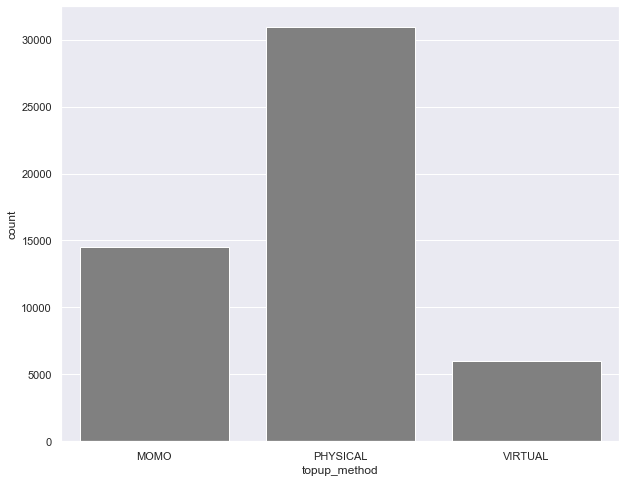

In [29]:
#data['topup_method'].value_counts().plot(kind='bar')
sns.countplot(data['topup_method'], color='gray')

In [30]:
#Covert the topup_method to dummy variables virtual,physical and momo
dummy = pd.get_dummies(data['topup_method'])

In [31]:
data = pd.concat([data,dummy],axis=1)
data.sample(n=5)

,customer_id,money_in_freq_6m,money_in_freq_3m,money_in_freq_1m,money_in_value_6m,money_in_value_3m,money_in_value_1m,money_in_acceptors_freq_6m,money_in_acceptors_freq_3m,money_in_acceptors_freq_1m,money_in_max_value_6m,money_in_max_value_3m,money_in_max_value_1m,money_out_freq_6m,money_out_freq_3m,money_out_freq_1m,money_out_value_6m,money_out_value_3m,money_out_value_1m,money_out_acceptors_freq_6m,money_out_acceptors_freq_3m,money_out_acceptors_freq_1m,money_out_max_value_6m,money_out_max_value_3m,money_out_max_value_1m,bill_payment_freq_6m,bill_payment_freq_3m,bill_payment_freq_1m,bill_payment_value_6m,bill_payment_value_3m,bill_payment_value_1m,bill_payment_acceptors_freq_6m,bill_payment_acceptors_freq_3m,bill_payment_acceptors_freq_1m,bill_payment_max_value_6m,bill_payment_max_value_3m,bill_payment_max_value_1m,transfer_out_freq_6m,transfer_out_freq_3m,transfer_out_freq_1m,transfer_out_value_6m,transfer_out_value_3m,transfer_out_value_1m,transfer_out_acceptors_freq_6m,transfer_out_acceptors_freq_3m,transfer_out_acceptors_freq_1m,transfer_out_max_value_6m,transfer_out_max_value_3m,transfer_out_max_value_1m,transfer_in_freq_6m,transfer_in_freq_3m,transfer_in_freq_1m,transfer_in_value_6m,transfer_in_value_3m,transfer_in_value_1m,transfer_in_acceptors_freq_6m,transfer_in_acceptors_freq_3m,transfer_in_acceptors_freq_1m,transfer_in_max_value_6m,transfer_in_max_value_3m,transfer_in_max_value_1m,account_transfer_freq_6m,account_transfer_freq_3m,account_transfer_freq_1m,account_transfer_value_6m,account_transfer_value_3m,account_transfer_value_1m,account_transfer_accptrs_freq_6m,account_transfer_accptrs_freq_3m,account_transfer_accptrs_freq_1m,account_transfer_max_value_6m,account_transfer_max_value_3m,account_transfer_max_value_1m,airtime_used_value_6m,airtime_used_value_3m,airtime_used_value_1m,days_airtime_below_freq_6m,days_airtime_below_freq_3m,days_airtime_below_freq_1m,days_since_last_active,active_days_freq_6m,active_days_freq_3m,active_days_freq_1m,topup_value_6m,topup_value_3m,topup_value_1m,topup_method,times_blocked_po_freq_6m,times_blocked_po_freq_3m,times_blocked_po_freq_1m,airtime_limit_amt,outgoing_calls_freq_6m,outgoing_calls_freq_3m,outgoing_calls_freq_1m,uniq_outgoing_calls_freq_6m,uniq_outgoing_calls_freq_3m,uniq_outgoing_calls_freq_1m,incoming_calls_freq_6m,incoming_calls_freq_3m,incoming_calls_freq_1m,uniq_incoming_calls_freq_6m,uniq_incoming_calls_freq_3m,uniq_incoming_calls_freq_1m,data_usage_value_6m,data_usage_value_3m,data_usage_value_1m,days_airtime_less_2mb_6m,days_airtime_less_2mb_3m,days_airtime_less_2mb_1m,avg_airtime_size_6m,avg_airtime_size_3m,avg_airtime_size_1m,airtime_received_freq_6m,airtime_received_freq_3m,airtime_received_freq_1m,airtime_received_value_6m,airtime_received_value_3m,airtime_received_value_1m,term_complete_yet,debt_duration,transfer_duration,account_lifespan,phone_usage_duration,unpaid_loan,MOMO,PHYSICAL,VIRTUAL
37334,42447009d82e5def6e78c4391f673e16,88.0,53.0,27.0,36556.0,25168.0,15769.0,22.0,14.0,7.0,2600.0,2600.0,2600.0,13.0,6.0,2.0,20995.0,18395.0,16380.0,2.0,1.0,0.0,10400.0,10400.0,10400.0,3.0,3.0,1.0,351.0,351.0,117.0,1.0,1.0,0.0,117.0,117.0,117.0,5.0,4.0,0.0,8729.5,2229.5,0.0,2.0,2.0,0.0,6500.0,1352.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,875.12,529.46,174.49,47.0,32.0,12.0,1.0,181.0,91.0,31.0,2083.9,1120.6,416.0,PHYSICAL,164.0,90.0,31.0,13000.0,3452.0,1779.0,711.0,0.0,0.0,0.0,2762.0,1432.0,508.0,0.0,0.0,0.0,4.415226e+09,2.716254e+09,4.880141e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4,-46100,45919,2782,0.0,0,1,0
21797,39b7c30aa01ef782af3920df77037fbd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.91,8.91,8.91,0.0,0.0,0.0,1.0,181.0,91.0,31.0,26.0,26.0,18.2,P

In [32]:
data.customer_id.nunique()

32339

In [33]:
data.drop_duplicates(subset=['customer_id'], inplace=True)

In [34]:
data.shape

(32339, 127)

In [35]:
data.sample(n=3)

,customer_id,money_in_freq_6m,money_in_freq_3m,money_in_freq_1m,money_in_value_6m,money_in_value_3m,money_in_value_1m,money_in_acceptors_freq_6m,money_in_acceptors_freq_3m,money_in_acceptors_freq_1m,money_in_max_value_6m,money_in_max_value_3m,money_in_max_value_1m,money_out_freq_6m,money_out_freq_3m,money_out_freq_1m,money_out_value_6m,money_out_value_3m,money_out_value_1m,money_out_acceptors_freq_6m,money_out_acceptors_freq_3m,money_out_acceptors_freq_1m,money_out_max_value_6m,money_out_max_value_3m,money_out_max_value_1m,bill_payment_freq_6m,bill_payment_freq_3m,bill_payment_freq_1m,bill_payment_value_6m,bill_payment_value_3m,bill_payment_value_1m,bill_payment_acceptors_freq_6m,bill_payment_acceptors_freq_3m,bill_payment_acceptors_freq_1m,bill_payment_max_value_6m,bill_payment_max_value_3m,bill_payment_max_value_1m,transfer_out_freq_6m,transfer_out_freq_3m,transfer_out_freq_1m,transfer_out_value_6m,transfer_out_value_3m,transfer_out_value_1m,transfer_out_acceptors_freq_6m,transfer_out_acceptors_freq_3m,transfer_out_acceptors_freq_1m,transfer_out_max_value_6m,transfer_out_max_value_3m,transfer_out_max_value_1m,transfer_in_freq_6m,transfer_in_freq_3m,transfer_in_freq_1m,transfer_in_value_6m,transfer_in_value_3m,transfer_in_value_1m,transfer_in_acceptors_freq_6m,transfer_in_acceptors_freq_3m,transfer_in_acceptors_freq_1m,transfer_in_max_value_6m,transfer_in_max_value_3m,transfer_in_max_value_1m,account_transfer_freq_6m,account_transfer_freq_3m,account_transfer_freq_1m,account_transfer_value_6m,account_transfer_value_3m,account_transfer_value_1m,account_transfer_accptrs_freq_6m,account_transfer_accptrs_freq_3m,account_transfer_accptrs_freq_1m,account_transfer_max_value_6m,account_transfer_max_value_3m,account_transfer_max_value_1m,airtime_used_value_6m,airtime_used_value_3m,airtime_used_value_1m,days_airtime_below_freq_6m,days_airtime_below_freq_3m,days_airtime_below_freq_1m,days_since_last_active,active_days_freq_6m,active_days_freq_3m,active_days_freq_1m,topup_value_6m,topup_value_3m,topup_value_1m,topup_method,times_blocked_po_freq_6m,times_blocked_po_freq_3m,times_blocked_po_freq_1m,airtime_limit_amt,outgoing_calls_freq_6m,outgoing_calls_freq_3m,outgoing_calls_freq_1m,uniq_outgoing_calls_freq_6m,uniq_outgoing_calls_freq_3m,uniq_outgoing_calls_freq_1m,incoming_calls_freq_6m,incoming_calls_freq_3m,incoming_calls_freq_1m,uniq_incoming_calls_freq_6m,uniq_incoming_calls_freq_3m,uniq_incoming_calls_freq_1m,data_usage_value_6m,data_usage_value_3m,data_usage_value_1m,days_airtime_less_2mb_6m,days_airtime_less_2mb_3m,days_airtime_less_2mb_1m,avg_airtime_size_6m,avg_airtime_size_3m,avg_airtime_size_1m,airtime_received_freq_6m,airtime_received_freq_3m,airtime_received_freq_1m,airtime_received_value_6m,airtime_received_value_3m,airtime_received_value_1m,term_complete_yet,debt_duration,transfer_duration,account_lifespan,phone_usage_duration,unpaid_loan,MOMO,PHYSICAL,VIRTUAL
44502,1a7180ef67b5f9c1002d2fff9d475fba,33.0,22.0,4.0,12220.0,4589.0,1657.5,9.0,8.0,3.0,4706.0,871.0,871.0,68.0,39.0,8.0,11910.6,4702.1,572.0,13.0,11.0,2.0,3900.0,780.0,390.0,7.0,6.0,1.0,1157.74,1072.66,247.52,1.0,1.0,0.0,247.52,247.52,247.52,12.0,11.0,10.0,2048.8,1788.8,1710.8,3.0,2.0,1.0,806.0,806.0,806.0,14.0,11.0,4.0,3614.0,3406.0,708.5,3.0,3.0,2.0,1326.0,1326.0,227.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.41,4.34,0.03,1.0,0.0,0.0,1.0,181.0,91.0,31.0,167.96,82.16,26.00,MOMO,167.0,90.0,31.0,81900.0,516.0,272.0,127.0,0.0,0.0,0.0,134.0,54.0,24.0,0.0,0.0,0.0,5.668789e+08,3.540859e+08,1.065678e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-2,-7,45822,2635,0.0,1,0,0
23320,15262b167648f62c5c014256a4827840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.10,0.00,0.00,1.0,0.0,0.0,7.0,175.0,85.0,25.0,75.40,0.00,

In [36]:
data.drop(['topup_method','customer_id'], axis=1, inplace=True)

In [37]:
data.sample(n=5)

,money_in_freq_6m,money_in_freq_3m,money_in_freq_1m,money_in_value_6m,money_in_value_3m,money_in_value_1m,money_in_acceptors_freq_6m,money_in_acceptors_freq_3m,money_in_acceptors_freq_1m,money_in_max_value_6m,money_in_max_value_3m,money_in_max_value_1m,money_out_freq_6m,money_out_freq_3m,money_out_freq_1m,money_out_value_6m,money_out_value_3m,money_out_value_1m,money_out_acceptors_freq_6m,money_out_acceptors_freq_3m,money_out_acceptors_freq_1m,money_out_max_value_6m,money_out_max_value_3m,money_out_max_value_1m,bill_payment_freq_6m,bill_payment_freq_3m,bill_payment_freq_1m,bill_payment_value_6m,bill_payment_value_3m,bill_payment_value_1m,bill_payment_acceptors_freq_6m,bill_payment_acceptors_freq_3m,bill_payment_acceptors_freq_1m,bill_payment_max_value_6m,bill_payment_max_value_3m,bill_payment_max_value_1m,transfer_out_freq_6m,transfer_out_freq_3m,transfer_out_freq_1m,transfer_out_value_6m,transfer_out_value_3m,transfer_out_value_1m,transfer_out_acceptors_freq_6m,transfer_out_acceptors_freq_3m,transfer_out_acceptors_freq_1m,transfer_out_max_value_6m,transfer_out_max_value_3m,transfer_out_max_value_1m,transfer_in_freq_6m,transfer_in_freq_3m,transfer_in_freq_1m,transfer_in_value_6m,transfer_in_value_3m,transfer_in_value_1m,transfer_in_acceptors_freq_6m,transfer_in_acceptors_freq_3m,transfer_in_acceptors_freq_1m,transfer_in_max_value_6m,transfer_in_max_value_3m,transfer_in_max_value_1m,account_transfer_freq_6m,account_transfer_freq_3m,account_transfer_freq_1m,account_transfer_value_6m,account_transfer_value_3m,account_transfer_value_1m,account_transfer_accptrs_freq_6m,account_transfer_accptrs_freq_3m,account_transfer_accptrs_freq_1m,account_transfer_max_value_6m,account_transfer_max_value_3m,account_transfer_max_value_1m,airtime_used_value_6m,airtime_used_value_3m,airtime_used_value_1m,days_airtime_below_freq_6m,days_airtime_below_freq_3m,days_airtime_below_freq_1m,days_since_last_active,active_days_freq_6m,active_days_freq_3m,active_days_freq_1m,topup_value_6m,topup_value_3m,topup_value_1m,times_blocked_po_freq_6m,times_blocked_po_freq_3m,times_blocked_po_freq_1m,airtime_limit_amt,outgoing_calls_freq_6m,outgoing_calls_freq_3m,outgoing_calls_freq_1m,uniq_outgoing_calls_freq_6m,uniq_outgoing_calls_freq_3m,uniq_outgoing_calls_freq_1m,incoming_calls_freq_6m,incoming_calls_freq_3m,incoming_calls_freq_1m,uniq_incoming_calls_freq_6m,uniq_incoming_calls_freq_3m,uniq_incoming_calls_freq_1m,data_usage_value_6m,data_usage_value_3m,data_usage_value_1m,days_airtime_less_2mb_6m,days_airtime_less_2mb_3m,days_airtime_less_2mb_1m,avg_airtime_size_6m,avg_airtime_size_3m,avg_airtime_size_1m,airtime_received_freq_6m,airtime_received_freq_3m,airtime_received_freq_1m,airtime_received_value_6m,airtime_received_value_3m,airtime_received_value_1m,term_complete_yet,debt_duration,transfer_duration,account_lifespan,phone_usage_duration,unpaid_loan,MOMO,PHYSICAL,VIRTUAL
32308,8.0,8.0,2.0,2489.5,2489.5,468.0,7.0,7.0,2.0,650.0,650.0,260.0,14.0,14.0,3.0,2242.5,2242.5,669.5,7.0,7.0,1.0,416.0,416.0,253.5,3.0,3.0,2.0,510.51,510.51,394.49,1.0,1.0,1.0,208.85,208.85,208.85,1.0,1.0,1.0,19.5,19.5,19.5,1.0,1.0,1.0,19.5,19.5,19.5,4.0,4.0,2.0,630.5,630.5,377.0,1.0,1.0,1.0,201.5,201.5,201.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.78,80.41,14.22,6.0,3.0,2.0,1.0,181.0,91.0,31.0,652.6,604.5,148.2,165.0,83.0,29.0,0.0,1081.0,754.0,249.0,0.0,0.0,0.0,961.0,666.0,260.0,0.0,0.0,0.0,2.444183e+09,2.119246e+09,693244250.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-2,0,44504,936,0.0,0,1,0
42582,5.0,3.0,1.0,1170.0,910.0,130.0,3.0,2.0,0.0,650.0,650.0,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,5.0,3.0,793.00,559.00,325.00,2.0,2.0,1.0,130.00,130.00,130.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,296.92,231.78,77.34,66.0,23.0,5.0,1.0,181.0,91.0,31.0,816.4,392.6,145.6,101.0,90.0,30.0,13000.0,1136.0,440.0,181.0,0.0,0.0,0.0,783.0,275.0,95.0,0.0,0.0,0.0,3.363

In [38]:
data.shape

(32339, 125)

In [39]:
data.describe()

,money_in_freq_6m,money_in_freq_3m,money_in_freq_1m,money_in_value_6m,money_in_value_3m,money_in_value_1m,money_in_acceptors_freq_6m,money_in_acceptors_freq_3m,money_in_acceptors_freq_1m,money_in_max_value_6m,money_in_max_value_3m,money_in_max_value_1m,money_out_freq_6m,money_out_freq_3m,money_out_freq_1m,money_out_value_6m,money_out_value_3m,money_out_value_1m,money_out_acceptors_freq_6m,money_out_acceptors_freq_3m,money_out_acceptors_freq_1m,money_out_max_value_6m,money_out_max_value_3m,money_out_max_value_1m,bill_payment_freq_6m,bill_payment_freq_3m,bill_payment_freq_1m,bill_payment_value_6m,bill_payment_value_3m,bill_payment_value_1m,bill_payment_acceptors_freq_6m,bill_payment_acceptors_freq_3m,bill_payment_acceptors_freq_1m,bill_payment_max_value_6m,bill_payment_max_value_3m,bill_payment_max_value_1m,transfer_out_freq_6m,transfer_out_freq_3m,transfer_out_freq_1m,transfer_out_value_6m,transfer_out_value_3m,transfer_out_value_1m,transfer_out_acceptors_freq_6m,transfer_out_acceptors_freq_3m,transfer_out_acceptors_freq_1m,transfer_out_max_value_6m,transfer_out_max_value_3m,transfer_out_max_value_1m,transfer_in_freq_6m,transfer_in_freq_3m,transfer_in_freq_1m,transfer_in_value_6m,transfer_in_value_3m,transfer_in_value_1m,transfer_in_acceptors_freq_6m,transfer_in_acceptors_freq_3m,transfer_in_acceptors_freq_1m,transfer_in_max_value_6m,transfer_in_max_value_3m,transfer_in_max_value_1m,account_transfer_freq_6m,account_transfer_freq_3m,account_transfer_freq_1m,account_transfer_value_6m,account_transfer_value_3m,account_transfer_value_1m,account_transfer_accptrs_freq_6m,account_transfer_accptrs_freq_3m,account_transfer_accptrs_freq_1m,account_transfer_max_value_6m,account_transfer_max_value_3m,account_transfer_max_value_1m,airtime_used_value_6m,airtime_used_value_3m,airtime_used_value_1m,days_airtime_below_freq_6m,days_airtime_below_freq_3m,days_airtime_below_freq_1m,days_since_last_active,active_days_freq_6m,active_days_freq_3m,active_days_freq_1m,topup_value_6m,topup_value_3m,topup_value_1m,times_blocked_po_freq_6m,times_blocked_po_freq_3m,times_blocked_po_freq_1m,airtime_limit_amt,outgoing_calls_freq_6m,outgoing_calls_freq_3m,outgoing_calls_freq_1m,uniq_outgoing_calls_freq_6m,uniq_outgoing_calls_freq_3m,uniq_outgoing_calls_freq_1m,incoming_calls_freq_6m,incoming_calls_freq_3m,incoming_calls_freq_1m,uniq_incoming_calls_freq_6m,uniq_incoming_calls_freq_3m,uniq_incoming_calls_freq_1m,data_usage_value_6m,data_usage_value_3m,data_usage_value_1m,days_airtime_less_2mb_6m,days_airtime_less_2mb_3m,days_airtime_less_2mb_1m,avg_airtime_size_6m,avg_airtime_size_3m,avg_airtime_size_1m,airtime_received_freq_6m,airtime_received_freq_3m,airtime_received_freq_1m,airtime_received_value_6m,airtime_received_value_3m,airtime_received_value_1m,term_complete_yet,debt_duration,transfer_duration,account_lifespan,phone_usage_duration,unpaid_loan,MOMO,PHYSICAL,VIRTUAL
count,32339.000000,32339.00000,32339.000000,3.233900e+04,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,3.233900e+04,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.0,32339.0,32339.0,32339.0,32339.0,32339.0,32339.0,32339.0,32339.0,32339.0,32339.0,32339.0,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,3.233900e+04,3.233900e+04,3.233900e+04,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,32339.000000,3.233900e+04,32339.0

In [40]:
data['default'] ="0"
data.loc[(data['unpaid_loan'] <= 0), 'default'] = '0'
data.loc[(data['unpaid_loan'] > 0), 'default'] = '1'

#data['default'] = data['default'].apply(lambda x: 1 if x == 'Yes' else 0)

In [41]:
data.drop(['unpaid_loan'],axis=1,inplace=True)
data.sample(n=3)

,money_in_freq_6m,money_in_freq_3m,money_in_freq_1m,money_in_value_6m,money_in_value_3m,money_in_value_1m,money_in_acceptors_freq_6m,money_in_acceptors_freq_3m,money_in_acceptors_freq_1m,money_in_max_value_6m,money_in_max_value_3m,money_in_max_value_1m,money_out_freq_6m,money_out_freq_3m,money_out_freq_1m,money_out_value_6m,money_out_value_3m,money_out_value_1m,money_out_acceptors_freq_6m,money_out_acceptors_freq_3m,money_out_acceptors_freq_1m,money_out_max_value_6m,money_out_max_value_3m,money_out_max_value_1m,bill_payment_freq_6m,bill_payment_freq_3m,bill_payment_freq_1m,bill_payment_value_6m,bill_payment_value_3m,bill_payment_value_1m,bill_payment_acceptors_freq_6m,bill_payment_acceptors_freq_3m,bill_payment_acceptors_freq_1m,bill_payment_max_value_6m,bill_payment_max_value_3m,bill_payment_max_value_1m,transfer_out_freq_6m,transfer_out_freq_3m,transfer_out_freq_1m,transfer_out_value_6m,transfer_out_value_3m,transfer_out_value_1m,transfer_out_acceptors_freq_6m,transfer_out_acceptors_freq_3m,transfer_out_acceptors_freq_1m,transfer_out_max_value_6m,transfer_out_max_value_3m,transfer_out_max_value_1m,transfer_in_freq_6m,transfer_in_freq_3m,transfer_in_freq_1m,transfer_in_value_6m,transfer_in_value_3m,transfer_in_value_1m,transfer_in_acceptors_freq_6m,transfer_in_acceptors_freq_3m,transfer_in_acceptors_freq_1m,transfer_in_max_value_6m,transfer_in_max_value_3m,transfer_in_max_value_1m,account_transfer_freq_6m,account_transfer_freq_3m,account_transfer_freq_1m,account_transfer_value_6m,account_transfer_value_3m,account_transfer_value_1m,account_transfer_accptrs_freq_6m,account_transfer_accptrs_freq_3m,account_transfer_accptrs_freq_1m,account_transfer_max_value_6m,account_transfer_max_value_3m,account_transfer_max_value_1m,airtime_used_value_6m,airtime_used_value_3m,airtime_used_value_1m,days_airtime_below_freq_6m,days_airtime_below_freq_3m,days_airtime_below_freq_1m,days_since_last_active,active_days_freq_6m,active_days_freq_3m,active_days_freq_1m,topup_value_6m,topup_value_3m,topup_value_1m,times_blocked_po_freq_6m,times_blocked_po_freq_3m,times_blocked_po_freq_1m,airtime_limit_amt,outgoing_calls_freq_6m,outgoing_calls_freq_3m,outgoing_calls_freq_1m,uniq_outgoing_calls_freq_6m,uniq_outgoing_calls_freq_3m,uniq_outgoing_calls_freq_1m,incoming_calls_freq_6m,incoming_calls_freq_3m,incoming_calls_freq_1m,uniq_incoming_calls_freq_6m,uniq_incoming_calls_freq_3m,uniq_incoming_calls_freq_1m,data_usage_value_6m,data_usage_value_3m,data_usage_value_1m,days_airtime_less_2mb_6m,days_airtime_less_2mb_3m,days_airtime_less_2mb_1m,avg_airtime_size_6m,avg_airtime_size_3m,avg_airtime_size_1m,airtime_received_freq_6m,airtime_received_freq_3m,airtime_received_freq_1m,airtime_received_value_6m,airtime_received_value_3m,airtime_received_value_1m,term_complete_yet,debt_duration,transfer_duration,account_lifespan,phone_usage_duration,MOMO,PHYSICAL,VIRTUAL,default
12044,2.0,0.0,0.0,247.0,0.0,0.0,2.0,0.0,0.0,130.0,0.0,0.0,6.0,0.0,0.0,2190.5,0.0,0.0,5.0,0.0,0.0,1794.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,2372.5,0.0,0.0,3.0,0.0,0.0,2015.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190.40,110.51,41.60,2.0,0.0,0.0,1.0,181.0,91.0,31.0,504.40,308.10,105.3,181.0,91.0,31.0,81900.0,2292.0,1357.0,452.0,0.0,0.0,0.0,2645.0,1460.0,443.0,0.0,0.0,0.0,3.571597e+08,190464262.3,24779827.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-45,46425,45003,144,0,1,0,0
7532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,234.0,234.0,234.0,1.0,1.0,1.0,91.0,91.0,91.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,273.0,273.0,273.0,1.0,1.0,1.0,273.0,273.0,273.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.61,32.20,11.04,4.0,3.0,2.0,1.0,181.0,91.0,31.0,343.20,273.00,74.1,168.0,85.0,31.0,81900.0,1264.0,860.0,287.0,0.0,0.0,0.0,2393.0,1358.0,460.0,0.0,0.0,0.0,1.252370e+08,37662171.3,2860035.1,0.0,0.0,0.0,0.0,0

In [42]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 

In [43]:
y= data['default']
X= data.drop(['default'],axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3, random_state=123)

In [44]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(22637, 124)
(9702, 124)
(22637,)
(9702,)


In [45]:
print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())

0
0


In [46]:
num_attr = X_train.select_dtypes(['int64','float']).columns
print(num_attr)

Index(['money_in_freq_6m', 'money_in_freq_3m', 'money_in_freq_1m',
       'money_in_value_6m', 'money_in_value_3m', 'money_in_value_1m',
       'money_in_acceptors_freq_6m', 'money_in_acceptors_freq_3m',
       'money_in_acceptors_freq_1m', 'money_in_max_value_6m',
       ...
       'airtime_received_freq_3m', 'airtime_received_freq_1m',
       'airtime_received_value_6m', 'airtime_received_value_3m',
       'airtime_received_value_1m', 'term_complete_yet', 'debt_duration',
       'transfer_duration', 'account_lifespan', 'phone_usage_duration'],
      dtype='object', length=121)


In [47]:
scaler = StandardScaler()
scaler.fit(X_train[num_attr])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [48]:
scaler.mean_

array([ 9.50837125e+00,  5.08318240e+00,  1.72257808e+00,  3.49261514e+03,
        1.92810330e+03,  6.80808730e+02,  3.44975041e+00,  1.95639882e+00,
        7.46786235e-01,  6.68961324e+02,  4.92861890e+02,  2.74142533e+02,
        8.43247780e+00,  4.60348103e+00,  1.59764987e+00,  2.81370904e+03,
        1.57322799e+03,  5.71278416e+02,  3.11459116e+00,  1.82122189e+00,
        7.20546009e-01,  5.93685714e+02,  4.31673853e+02,  2.37508800e+02,
        2.65437116e+00,  1.44542121e+00,  4.92335557e-01,  5.23075687e+02,
        2.84673651e+02,  1.00888919e+02,  4.98210894e-01,  3.44789504e-01,
        1.66983257e-01,  1.01841276e+02,  7.65875072e+01,  4.63444957e+01,
        2.97751469e+00,  1.59195123e+00,  5.59349737e-01,  1.06369266e+03,
        5.78736076e+02,  2.02761528e+02,  1.09674427e+00,  5.92083757e-01,
        2.33776560e-01,  2.76339369e+02,  1.92763515e+02,  9.87895264e+01,
        3.75213147e+00,  2.04320360e+00,  7.28276715e-01,  1.22141377e+03,
        6.81520383e+02,  

In [49]:
X_train[num_attr]=scaler.transform(X_train[num_attr]) #standardize train and tst
X_test[num_attr]=scaler.transform(X_test[num_attr])

In [50]:
print(X_train.shape)
print(X_test.shape)

(22637, 124)
(9702, 124)


In [51]:
X_train.sample(n=2)

,money_in_freq_6m,money_in_freq_3m,money_in_freq_1m,money_in_value_6m,money_in_value_3m,money_in_value_1m,money_in_acceptors_freq_6m,money_in_acceptors_freq_3m,money_in_acceptors_freq_1m,money_in_max_value_6m,money_in_max_value_3m,money_in_max_value_1m,money_out_freq_6m,money_out_freq_3m,money_out_freq_1m,money_out_value_6m,money_out_value_3m,money_out_value_1m,money_out_acceptors_freq_6m,money_out_acceptors_freq_3m,money_out_acceptors_freq_1m,money_out_max_value_6m,money_out_max_value_3m,money_out_max_value_1m,bill_payment_freq_6m,bill_payment_freq_3m,bill_payment_freq_1m,bill_payment_value_6m,bill_payment_value_3m,bill_payment_value_1m,bill_payment_acceptors_freq_6m,bill_payment_acceptors_freq_3m,bill_payment_acceptors_freq_1m,bill_payment_max_value_6m,bill_payment_max_value_3m,bill_payment_max_value_1m,transfer_out_freq_6m,transfer_out_freq_3m,transfer_out_freq_1m,transfer_out_value_6m,transfer_out_value_3m,transfer_out_value_1m,transfer_out_acceptors_freq_6m,transfer_out_acceptors_freq_3m,transfer_out_acceptors_freq_1m,transfer_out_max_value_6m,transfer_out_max_value_3m,transfer_out_max_value_1m,transfer_in_freq_6m,transfer_in_freq_3m,transfer_in_freq_1m,transfer_in_value_6m,transfer_in_value_3m,transfer_in_value_1m,transfer_in_acceptors_freq_6m,transfer_in_acceptors_freq_3m,transfer_in_acceptors_freq_1m,transfer_in_max_value_6m,transfer_in_max_value_3m,transfer_in_max_value_1m,account_transfer_freq_6m,account_transfer_freq_3m,account_transfer_freq_1m,account_transfer_value_6m,account_transfer_value_3m,account_transfer_value_1m,account_transfer_accptrs_freq_6m,account_transfer_accptrs_freq_3m,account_transfer_accptrs_freq_1m,account_transfer_max_value_6m,account_transfer_max_value_3m,account_transfer_max_value_1m,airtime_used_value_6m,airtime_used_value_3m,airtime_used_value_1m,days_airtime_below_freq_6m,days_airtime_below_freq_3m,days_airtime_below_freq_1m,days_since_last_active,active_days_freq_6m,active_days_freq_3m,active_days_freq_1m,topup_value_6m,topup_value_3m,topup_value_1m,times_blocked_po_freq_6m,times_blocked_po_freq_3m,times_blocked_po_freq_1m,airtime_limit_amt,outgoing_calls_freq_6m,outgoing_calls_freq_3m,outgoing_calls_freq_1m,uniq_outgoing_calls_freq_6m,uniq_outgoing_calls_freq_3m,uniq_outgoing_calls_freq_1m,incoming_calls_freq_6m,incoming_calls_freq_3m,incoming_calls_freq_1m,uniq_incoming_calls_freq_6m,uniq_incoming_calls_freq_3m,uniq_incoming_calls_freq_1m,data_usage_value_6m,data_usage_value_3m,data_usage_value_1m,days_airtime_less_2mb_6m,days_airtime_less_2mb_3m,days_airtime_less_2mb_1m,avg_airtime_size_6m,avg_airtime_size_3m,avg_airtime_size_1m,airtime_received_freq_6m,airtime_received_freq_3m,airtime_received_freq_1m,airtime_received_value_6m,airtime_received_value_3m,airtime_received_value_1m,term_complete_yet,debt_duration,transfer_duration,account_lifespan,phone_usage_duration,MOMO,PHYSICAL,VIRTUAL
21334,-0.027200,0.184555,-0.434661,0.048266,0.057646,-0.145068,0.473713,0.910957,-0.486256,0.464129,0.581700,-0.314063,0.363323,0.809779,-0.159649,0.073061,0.111292,-0.068790,1.550703,2.166788,0.177260,0.526047,0.337433,0.011272,0.062119,0.179784,-0.097294,-0.004194,0.068206,-0.058479,0.579870,0.917357,-0.354565,0.209851,0.320764,-0.191984,-0.057023,-0.066690,-0.16038,-0.065289,-0.107749,-0.113574,0.134740,0.111192,-0.15024,0.128505,-0.159154,-0.198854,0.407537,0.517232,0.067043,0.023162,0.07990,0.006524,0.135745,0.356714,-0.186437,-0.066586,0.049121,0.283279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.166316,0.820486,0.431258,0.295128,0.321864,-0.205358,-0.139354,0.017945,0.017782,0.017677,1.199938,2.082460,2.035028,0.413541,0.022205,0.218532,-0.017927,1.408478,1.299657,0.814921,0.0,0.0,0.0,1.256679,1.222240,1.027616,0.0,0.0,0.0,0.391824,0.354196,1.386586,0.0,0.0,0.0,0.0,0.0,0.0,-0.054393,-0.032974,-0.027423,-0.054506,-0.033053,-0.027481,0.173431,-0.125754,-0.338955,0.428665,-0.085667,0,1,0
21794,0.133315,0.088273,-0.182329,0.228724,0.206246,-0.110442,0.659464,0.611655,-0.486256,0.942205,0.470023,

In [52]:
X_test.sample(n=1)

,money_in_freq_6m,money_in_freq_3m,money_in_freq_1m,money_in_value_6m,money_in_value_3m,money_in_value_1m,money_in_acceptors_freq_6m,money_in_acceptors_freq_3m,money_in_acceptors_freq_1m,money_in_max_value_6m,money_in_max_value_3m,money_in_max_value_1m,money_out_freq_6m,money_out_freq_3m,money_out_freq_1m,money_out_value_6m,money_out_value_3m,money_out_value_1m,money_out_acceptors_freq_6m,money_out_acceptors_freq_3m,money_out_acceptors_freq_1m,money_out_max_value_6m,money_out_max_value_3m,money_out_max_value_1m,bill_payment_freq_6m,bill_payment_freq_3m,bill_payment_freq_1m,bill_payment_value_6m,bill_payment_value_3m,bill_payment_value_1m,bill_payment_acceptors_freq_6m,bill_payment_acceptors_freq_3m,bill_payment_acceptors_freq_1m,bill_payment_max_value_6m,bill_payment_max_value_3m,bill_payment_max_value_1m,transfer_out_freq_6m,transfer_out_freq_3m,transfer_out_freq_1m,transfer_out_value_6m,transfer_out_value_3m,transfer_out_value_1m,transfer_out_acceptors_freq_6m,transfer_out_acceptors_freq_3m,transfer_out_acceptors_freq_1m,transfer_out_max_value_6m,transfer_out_max_value_3m,transfer_out_max_value_1m,transfer_in_freq_6m,transfer_in_freq_3m,transfer_in_freq_1m,transfer_in_value_6m,transfer_in_value_3m,transfer_in_value_1m,transfer_in_acceptors_freq_6m,transfer_in_acceptors_freq_3m,transfer_in_acceptors_freq_1m,transfer_in_max_value_6m,transfer_in_max_value_3m,transfer_in_max_value_1m,account_transfer_freq_6m,account_transfer_freq_3m,account_transfer_freq_1m,account_transfer_value_6m,account_transfer_value_3m,account_transfer_value_1m,account_transfer_accptrs_freq_6m,account_transfer_accptrs_freq_3m,account_transfer_accptrs_freq_1m,account_transfer_max_value_6m,account_transfer_max_value_3m,account_transfer_max_value_1m,airtime_used_value_6m,airtime_used_value_3m,airtime_used_value_1m,days_airtime_below_freq_6m,days_airtime_below_freq_3m,days_airtime_below_freq_1m,days_since_last_active,active_days_freq_6m,active_days_freq_3m,active_days_freq_1m,topup_value_6m,topup_value_3m,topup_value_1m,times_blocked_po_freq_6m,times_blocked_po_freq_3m,times_blocked_po_freq_1m,airtime_limit_amt,outgoing_calls_freq_6m,outgoing_calls_freq_3m,outgoing_calls_freq_1m,uniq_outgoing_calls_freq_6m,uniq_outgoing_calls_freq_3m,uniq_outgoing_calls_freq_1m,incoming_calls_freq_6m,incoming_calls_freq_3m,incoming_calls_freq_1m,uniq_incoming_calls_freq_6m,uniq_incoming_calls_freq_3m,uniq_incoming_calls_freq_1m,data_usage_value_6m,data_usage_value_3m,data_usage_value_1m,days_airtime_less_2mb_6m,days_airtime_less_2mb_3m,days_airtime_less_2mb_1m,avg_airtime_size_6m,avg_airtime_size_3m,avg_airtime_size_1m,airtime_received_freq_6m,airtime_received_freq_3m,airtime_received_freq_1m,airtime_received_value_6m,airtime_received_value_3m,airtime_received_value_1m,term_complete_yet,debt_duration,transfer_duration,account_lifespan,phone_usage_duration,MOMO,PHYSICAL,VIRTUAL
18288,-0.508745,-0.489418,-0.434661,-0.189755,-0.175616,-0.145068,-0.640796,-0.585555,-0.486256,-0.492021,-0.423396,-0.314063,-0.550283,-0.503994,-0.426778,-0.160441,-0.148032,-0.121187,-0.612499,-0.549704,-0.457049,-0.459062,-0.389129,-0.282064,-0.122534,-0.101725,-0.097294,-0.108081,-0.089023,-0.058479,-0.575735,-0.482738,-0.354565,-0.312775,-0.262512,-0.191984,-0.173694,-0.179351,-0.16038,-0.116583,-0.124533,-0.113574,-0.163602,-0.161393,-0.15024,-0.31243,-0.267325,-0.198854,-0.210977,-0.213204,-0.179689,-0.154945,-0.151902,-0.132438,-0.203985,-0.209253,-0.186437,-0.382638,-0.32306,-0.252845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.328623,-0.30397,-0.298283,-0.724434,-0.665728,-0.57549,-0.052811,0.014434,0.016026,0.017091,-0.621178,-0.610973,-0.577786,-1.334647,-0.620953,0.500901,-0.021946,-0.810145,-0.769947,-0.700239,0.0,0.0,0.0,-0.870391,-0.84368,-0.793676,0.0,0.0,0.0,-0.156315,-0.115736,-0.241974,0.0,0.0,0.0,0.0,0.0,0.0,-0.054393,-0.032974,-0.027423,-0.054506,-0.033053,-0.027481,0.173431,-0.122527,-0.341291,-2.02748,0.390097,1,0,0


In [53]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score
from sklearn.metrics import mean_absolute_error

In [54]:
scores = {}

for n_estimators in range(2, 100):
    RF_model = RandomForestClassifier(n_estimators=n_estimators, random_state=0)
    RF_model.fit(X_train, y_train)
    RF_predictions = RF_model.predict(X_test)
    RF_mae = mean_absolute_error(RF_predictions, y_test)
    scores[n_estimators] = RF_mae

In [55]:
best_n_estimators = []

for n_estimators, score in scores.items():
    if score == min(scores.values()):
        best_n_estimators.append(n_estimators)

print(f"Best Number of Estimators: {min(best_n_estimators)}")

Best Number of Estimators: 64


In [56]:
from sklearn.metrics import classification_report

In [57]:
rf_clf = RandomForestClassifier(n_estimators=min(best_n_estimators), random_state=0)

rf_clf.fit(X_train, y_train)
score_train = rf_clf.score(X_train, y_train)
print('Training Accuracy : ' + str(score_train))

score_valid = rf_clf.score(X_test, y_test)
print('Validation Accuracy : ' + str(score_valid))

print()
print(classification_report(y_test, rf_clf.predict(X_test)))

Training Accuracy : 0.9982329814021292
Validation Accuracy : 0.8378684807256236

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      8122
           1       0.56      0.02      0.04      1580

    accuracy                           0.84      9702
   macro avg       0.70      0.51      0.47      9702
weighted avg       0.79      0.84      0.77      9702



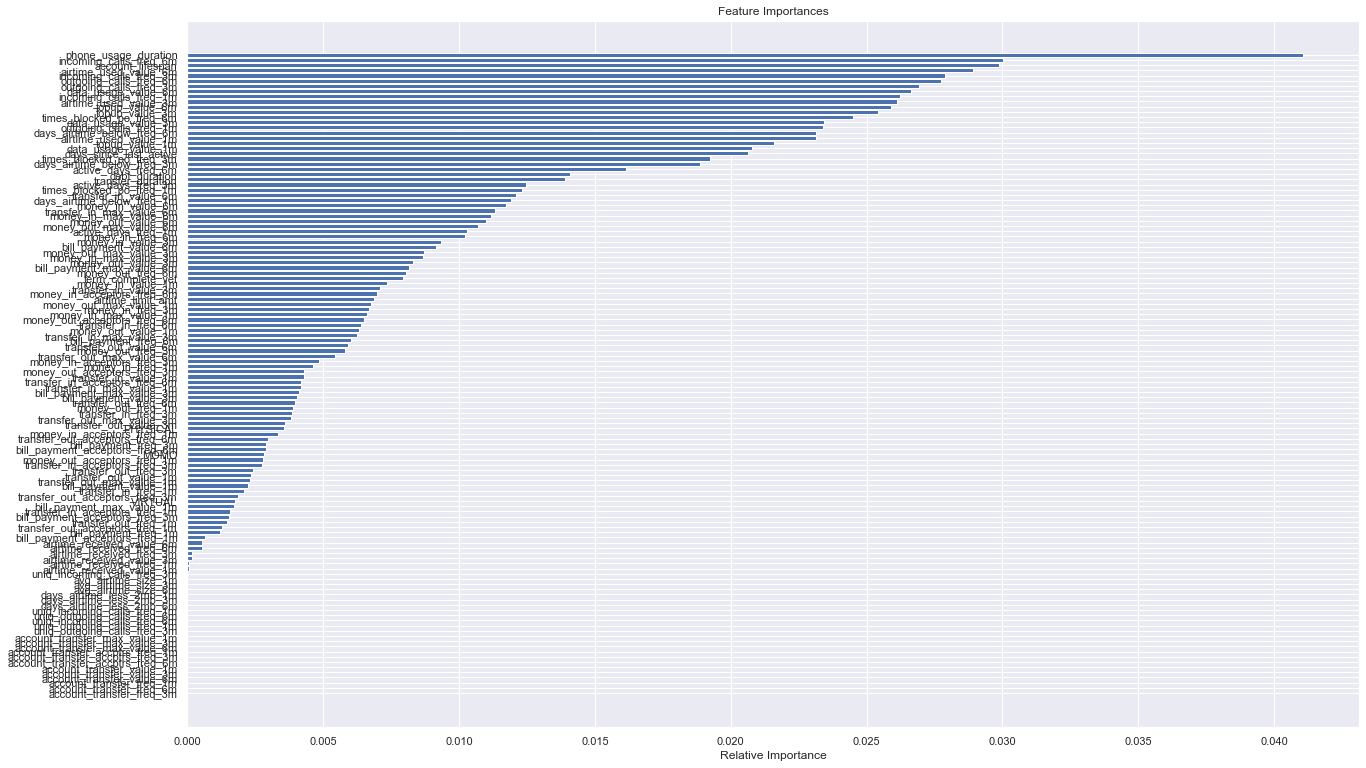

In [58]:
features = X_train.columns 

fig, ax = plt.subplots(figsize=(21, 13))
plt.title('Feature Importances')
importances = rf_clf.feature_importances_
indices = np.argsort(importances)
ax.barh(range(len(indices)), importances[indices],color='b')
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.show()

In [59]:
feature_importances = pd.DataFrame(rf_clf.feature_importances_,index = X_train.columns,columns=['importance']).sort_values('importance', ascending=False)
feature_importances = feature_importances.reset_index()
feature_importances.head(7)

,index,importance
0,phone_usage_duration,0.041078
1,incoming_calls_freq_6m,0.030021
2,account_lifespan,0.029888
3,airtime_used_value_6m,0.028917
4,incoming_calls_freq_3m,0.027882
5,outgoing_calls_freq_6m,0.027758
6,outgoing_calls_freq_3m,0.026922


In [60]:
data = data[['phone_usage_duration','account_lifespan','incoming_calls_freq_6m','outgoing_calls_freq_6m','incoming_calls_freq_3m','airtime_used_value_6m','outgoing_calls_freq_3m','default']]

In [61]:
print(data.shape)
data.sample(4)

(32339, 8)


,phone_usage_duration,account_lifespan,incoming_calls_freq_6m,outgoing_calls_freq_6m,incoming_calls_freq_3m,airtime_used_value_6m,outgoing_calls_freq_3m,default
47298,2498,45631,448.0,218.0,131.0,14.76,89.0,1
29060,780,45405,619.0,447.0,318.0,57.68,339.0,0
6867,3108,46235,2552.0,4425.0,1781.0,481.91,2862.0,0
34504,1169,44466,0.0,6.0,0.0,0.75,0.0,0


In [62]:
data.dtypes

phone_usage_duration        int64
account_lifespan            int64
incoming_calls_freq_6m    float64
outgoing_calls_freq_6m    float64
incoming_calls_freq_3m    float64
airtime_used_value_6m     float64
outgoing_calls_freq_3m    float64
default                    object
dtype: object

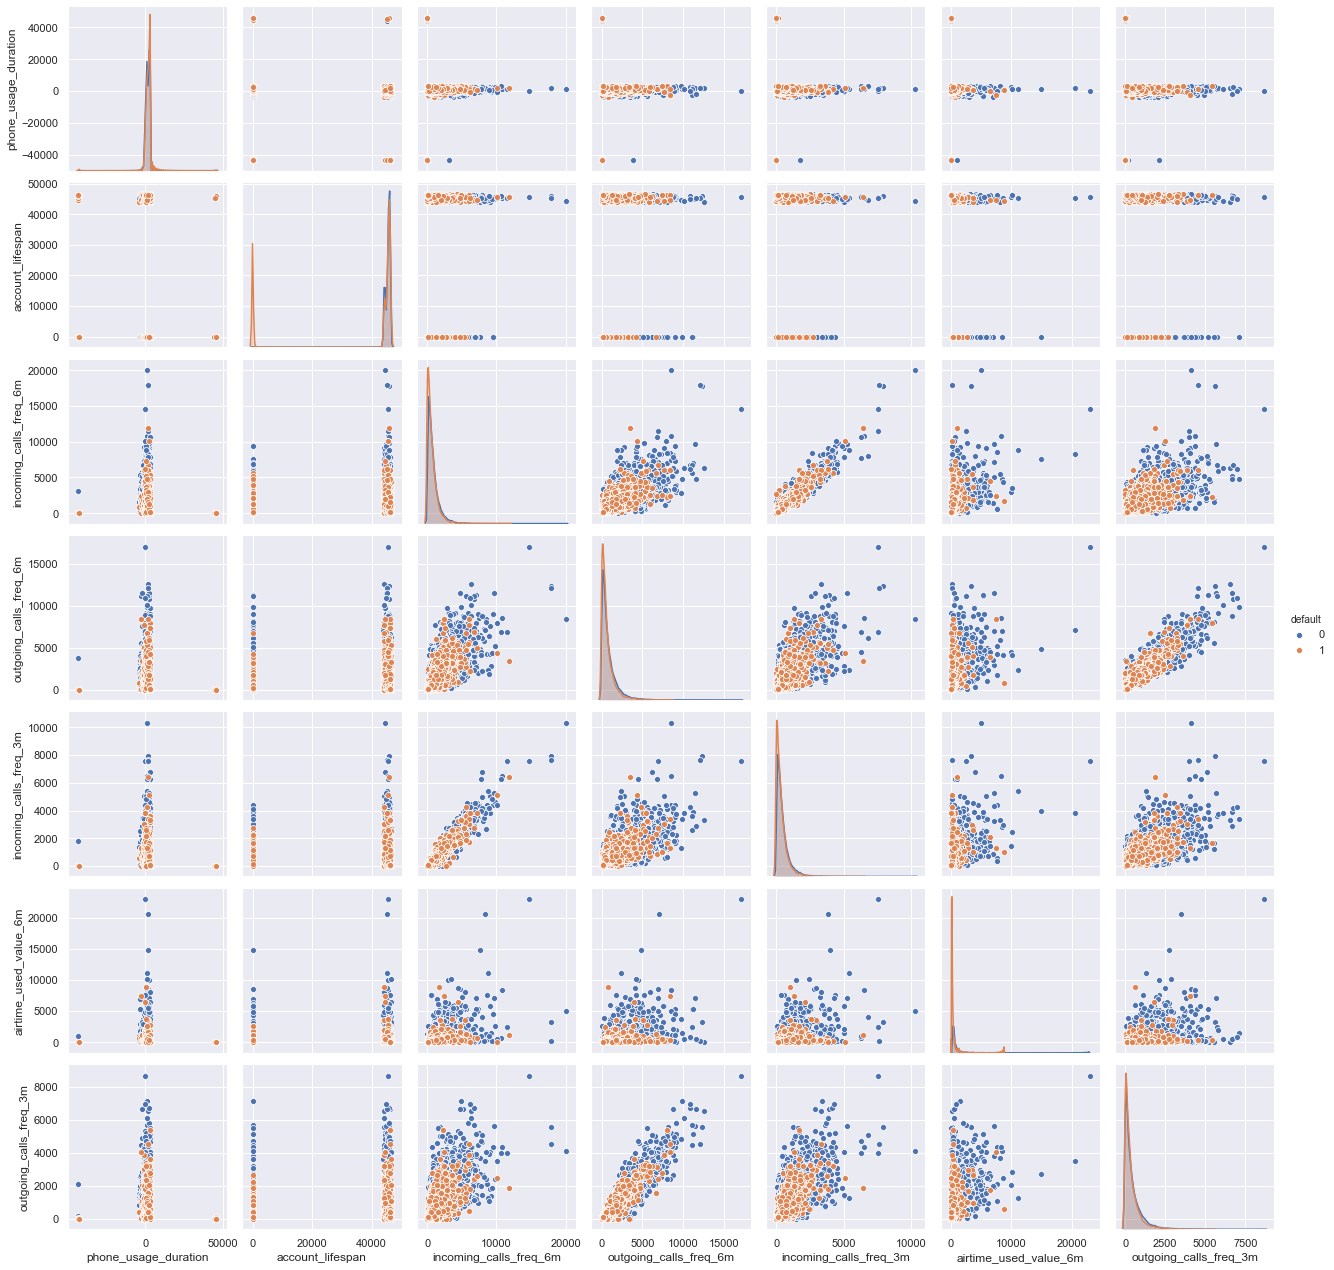

In [63]:
sns.pairplot(data, hue='default');

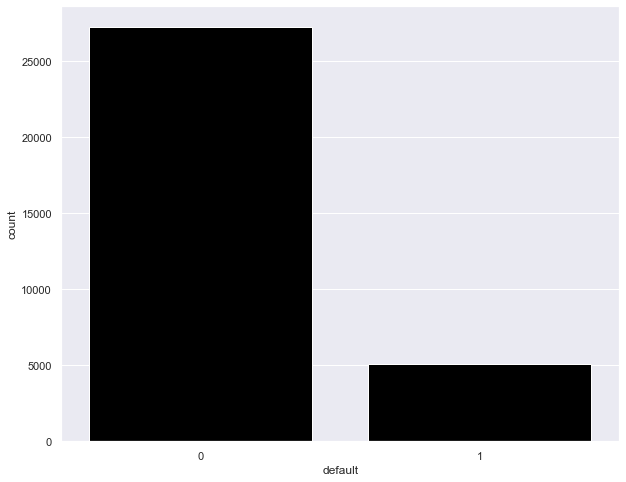

In [64]:
sns.countplot(data['default'], color='black');

In [65]:
data['default'].value_counts()

0    27248
1     5091
Name: default, dtype: int64

In [66]:
XGB_model = XGBClassifier(n_estimators=500, gamma=0.5,learning_rate=0.1)
%time XGB_model.fit(X_train, y_train)
y_pred = XGB_model.predict(X_test)
print(accuracy_score(y_test,y_pred))

CPU times: user 1min 16s, sys: 272 ms, total: 1min 16s
Wall time: 1min 16s
0.8351886209029066


In [67]:
XGB = XGBClassifier(n_jobs=-1)
 
# Use a grid over parameters of interest
param_grid = {
     'colsample_bytree': np.linspace(0.5, 0.9, 2),
     'n_estimators':[100],
     'max_depth': [10, 15]
}

 
CV_XGB = GridSearchCV(estimator=XGB, param_grid=param_grid, cv= 10)

In [68]:
%time CV_XGB.fit(X = X_train, y=y_train)

CPU times: user 25min 37s, sys: 13.9 s, total: 25min 51s
Wall time: 25min 52s


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': array([0.5, 0.9]),
                         'max_depth': [10, 15], 'n_estimators': [100]},
             pre_dispatch='2*n_jobs', r

In [69]:
# Find best model
best_xgb_model = CV_XGB.best_estimator_
print (CV_XGB.best_score_, CV_XGB.best_params_)

0.8453416381831553 {'colsample_bytree': 0.5, 'max_depth': 10, 'n_estimators': 100}


In [70]:
y_pred_test=best_xgb_model.predict(X_test)

In [71]:
print(accuracy_score(y_test,y_pred_test))

0.8379715522572665


In [73]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [74]:
print(confusion_matrix(y_test, y_pred_test))

[[8072   50]
 [1522   58]]


### Using Multiple Layer Perceptrons (MLP)

In [75]:
#conda install tensorflow 

In [76]:
#conda install keras

In [77]:
import os
import tensorflow as tf
from keras.regularizers import l2
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.utils import to_categorical
from keras import optimizers
from keras.callbacks import Callback
from keras import backend as K

#### MLP with 4 layers
- 1st hidden layer with 25 neurons
- 2nd hidden layer with 20 neurons
- 3nd hidden layer with 15 neurons

In [78]:
np.random.seed(123)

#tf.random.set_seed(123)

In [79]:
model= Sequential()

In [93]:
len(X_train)

22637

In [92]:
model = Sequential()
model.add(Dense(16, input_dim=len(X_train), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

TypeError: add() got an unexpected keyword argument 'activation'

In [ ]:
mlp_model.summary()

In [ ]:
mlp_model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [ ]:
mlp_model.fit(X_train, y_train, batch_size="32", epochs="100")

#### Predictions 

In [ ]:
train_model_pred = mlp_model.predict_classes(X_train)
test_model_pred = mlp_model.predict_classes(X_test)

In [ ]:
confusion_matrix_train = confusion_matrix(y_train, train_model_pred)
confusion_matrix_test = confusion_matrix(y_test, test_model_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

In [ ]:
Accuracy_Train_M6 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M6 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M6 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M6)
print("Train TPR: ",TPR_Train_M6)
print("Train Accuracy: ",Accuracy_Train_M6)

print("-----------------------")

Accuracy_Test_M6 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M6 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M6 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M6)
print("Test TPR: ",TPR_Test_M6)
print("Test Accuracy: ",Accuracy_Test_M6)